In [35]:
import numpy as np
import pennylane as qml
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from pennylane import draw

In [2]:
data = load_breast_cancer()
X = data.data[:, :4]  
y = data.target

In [3]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [4]:
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

In [21]:
@qml.qnode(dev)
def prepare_state(x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    return qml.state()

In [6]:
def quantum_kernel(x1, x2):
    state1 = prepare_state(x1)
    state2 = prepare_state(x2)
    fidelity = np.abs(np.dot(np.conj(state1), state2)) ** 2
    return fidelity

In [7]:
def compute_kernel_matrix(X1, X2):
    kernel_matrix = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            kernel_matrix[i, j] = quantum_kernel(X1[i], X2[j])
    return kernel_matrix

In [8]:
print("Computing quantum kernel matrix...")
X_train_kernel = compute_kernel_matrix(X_train, X_train)
X_test_kernel = compute_kernel_matrix(X_test, X_train)
clf = SVC(kernel="precomputed")
clf.fit(X_train_kernel, y_train)
train_accuracy = clf.score(X_train_kernel, y_train)
test_accuracy = clf.score(X_test_kernel, y_test)
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Computing quantum kernel matrix...

Train Accuracy: 0.8879
Test Accuracy: 0.9123


In [9]:
def predict_new_sample(sample, X_train, scaler, clf):
    sample_scaled = scaler.transform([sample])[:, :4]
    sample_kernel = np.array([quantum_kernel(sample_scaled[0], x) for x in X_train])
    sample_kernel = sample_kernel.reshape(1, -1)
    prediction = clf.predict(sample_kernel)
    return prediction[0]
new_input = [15.0, 12.5, 80.0, 500.0]
predicted_class = predict_new_sample(new_input, X_train, scaler, clf)
print(f"\nPredicted class for new input: {predicted_class} ({'Benign' if predicted_class == 1 else 'Malignant'})")


Predicted class for new input: 1 (Benign)


In [10]:
np.set_printoptions(precision=3, suppress=True)
print("\nQuantum Kernel Matrix (Training Set):")
print(X_train_kernel)
print("\nQuantum Kernel Matrix (Test Set):")
print(X_test_kernel)


Quantum Kernel Matrix (Training Set):
[[1.    0.784 0.997 ... 0.967 0.967 0.986]
 [0.784 1.    0.77  ... 0.898 0.907 0.87 ]
 [0.997 0.77  1.    ... 0.966 0.961 0.977]
 ...
 [0.967 0.898 0.966 ... 1.    0.998 0.99 ]
 [0.967 0.907 0.961 ... 0.998 1.    0.995]
 [0.986 0.87  0.977 ... 0.99  0.995 1.   ]]

Quantum Kernel Matrix (Test Set):
[[0.985 0.872 0.98  ... 0.995 0.997 0.999]
 [0.864 0.984 0.857 ... 0.959 0.961 0.931]
 [0.944 0.936 0.938 ... 0.995 0.996 0.983]
 ...
 [0.991 0.831 0.993 ... 0.989 0.985 0.991]
 [0.935 0.924 0.914 ... 0.966 0.981 0.978]
 [0.766 0.993 0.745 ... 0.874 0.889 0.855]]


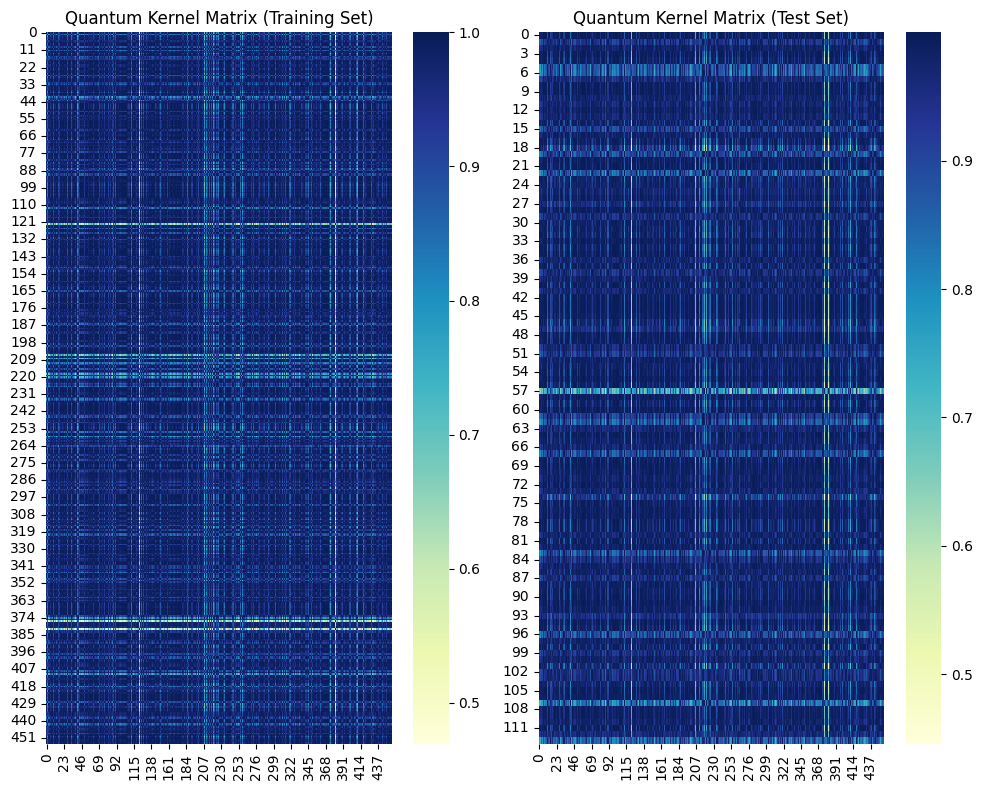

In [13]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.heatmap(X_train_kernel, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Quantum Kernel Matrix (Training Set)")
plt.subplot(1, 2, 2)
sns.heatmap(X_test_kernel, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Quantum Kernel Matrix (Test Set)")
plt.tight_layout()
plt.show()

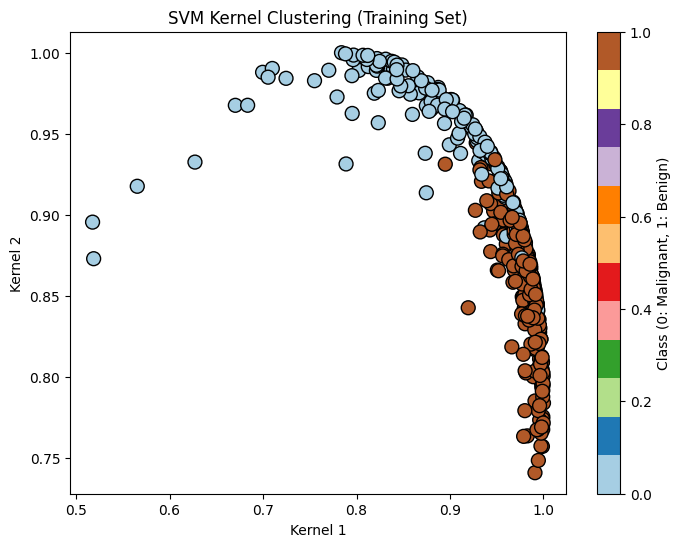

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_kernel[:, 0], X_train_kernel[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', s=100)
plt.title("SVM Kernel Clustering (Training Set)")
plt.xlabel("Kernel 1")
plt.ylabel("Kernel 2")
plt.colorbar(label="Class (0: Malignant, 1: Benign)")
plt.show()